In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def volume_price_correlation(df, n=20):
    """
    计算成交量变化与价格变动的滚动相关性因子
    1. 计算对数成交量的变化率
    2. 计算价格变动率 (收盘价相对开盘价的变化)
    3. 对两者进行滚动排名
    4. 计算滚动窗口内的相关系数并取负值
    
    参数:
    df: 包含OHLCV数据的DataFrame
    n: 滚动窗口大小 (默认20)
    """
    # 计算log(volume)的一阶差分
    df = df.copy()
    df['log_volume'] = np.log(df['volume'])
    df['delta_log_volume'] = df['log_volume'].diff(1)
    
    # 计算(close-open)/open
    df['close_open_ratio'] = (df['close'] - df['open']) / df['open']
    
    # 创建滚动排名列
    df['rank_delta_log_volume'] = df['delta_log_volume'].rolling(n, min_periods=1).apply(
        lambda x: (pd.Series(x).rank(pct=True).iloc[-1]), raw=False)
    
    df['rank_close_open_ratio'] = df['close_open_ratio'].rolling(n, min_periods=1).apply(
        lambda x: (pd.Series(x).rank(pct=True).iloc[-1]), raw=False)
    
    # 计算滚动相关系数
    factor = df['rank_delta_log_volume'].rolling(n).corr(df['rank_close_open_ratio'])
    
    return factor

In [5]:
evaluator.set_factor(
    factor_data_or_func=volume_price_correlation,
    factor_name='volume_price_correlation'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.003351
   Rank_IC (Spearman): -0.038347
📊 信息比率:
   IR: 0.227193
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130204
   因子列: volume_price_correlation
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


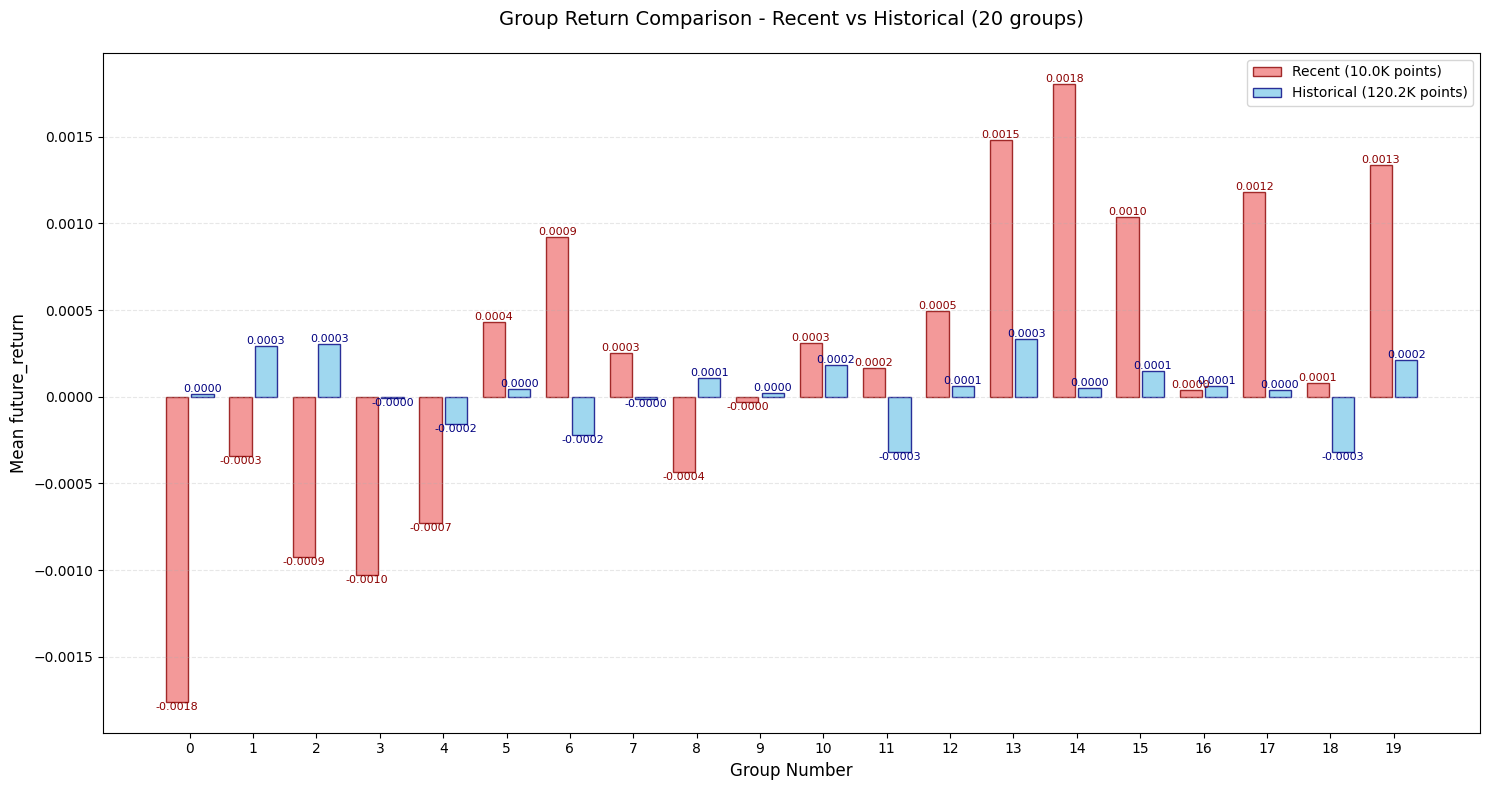

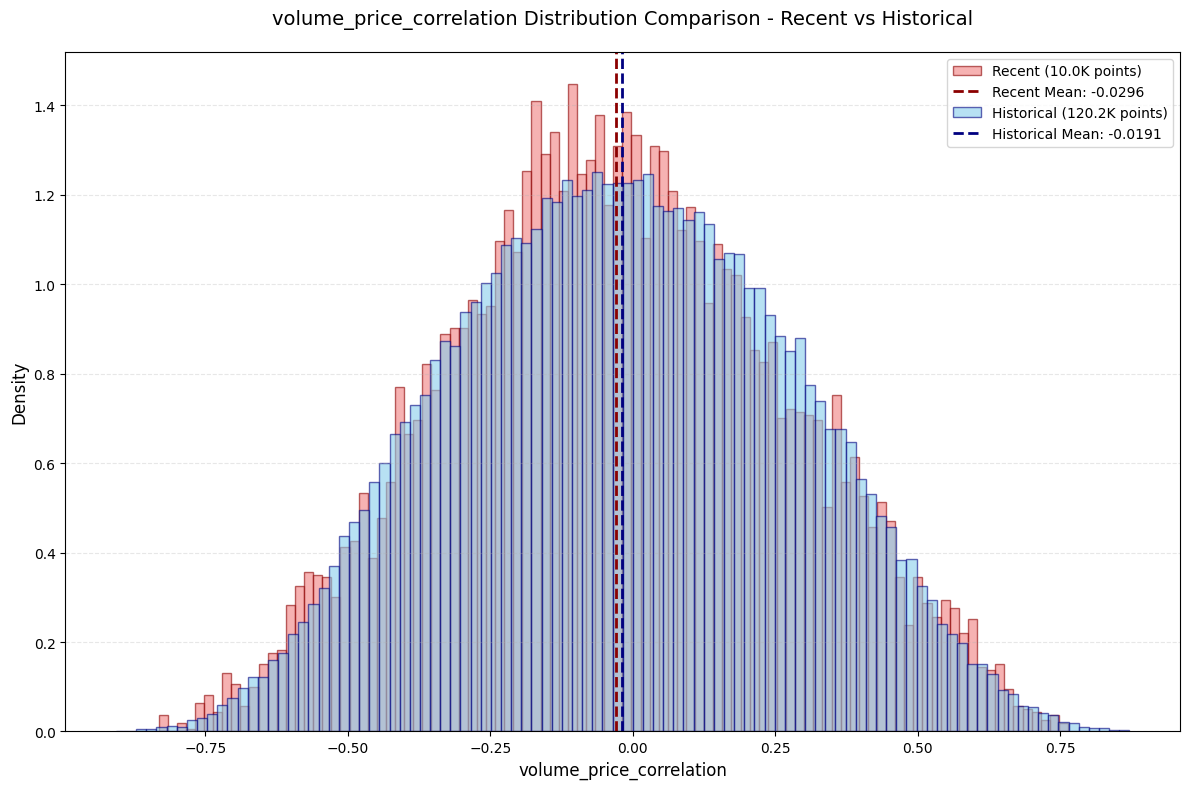

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [7]:
# 获取分组数据
group_data = evaluator.get_group_data()

# 分析分组数据
if group_data is not None:
    # 打印每组统计信息
    print("\n📊 分组详细信息:")
    print("="*50)
    
    # 获取分组数量（实际有效分组数）
    num_groups = group_data['group'].nunique()
    
    # 按组分析
    group_stats = group_data.groupby('group').agg({
        'volume_price_correlation': ['mean', 'std', 'min', 'max'],
        'future_return': ['mean', 'std', 'min', 'max']
    })
    
    # 重命名列以便阅读
    group_stats.columns = ['因子均值', '因子标准差', '因子最小值', '因子最大值',
                          '收益均值', '收益标准差', '收益最小值', '收益最大值']
    
    print(f"有效分组数量: {num_groups}")
    print(group_stats)
    
    # 分析分组收益差异
    top_group = group_data[group_data['group'] == num_groups]
    bottom_group = group_data[group_data['group'] == 1]
    
    print("\n🔝 顶级组 vs 🔻 底层组 表现对比:")
    print(f"顶级组平均收益: {top_group['future_return'].mean():.6f}")
    print(f"底层组平均收益: {bottom_group['future_return'].mean():.6f}")
    print(f"组间收益差异: {top_group['future_return'].mean() - bottom_group['future_return'].mean():.6f}")
else:
    print("⚠️ 未获取到分组数据，请检查评估器实现")

AttributeError: 'FactorEvaluation' object has no attribute 'get_group_data'